<a href="https://colab.research.google.com/github/arash-hbm/python-notebooks/blob/main/grounded_sam_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Grounded SAM Inpainting Demo](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

## Why this project?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment everything** with text inputs!



## Install

In [ ]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1613, done.
remote: Counting objects: 100% (516/516), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 1613 (delta 451), reused 391 (delta 385), pack-reused 1097
Receiving objects: 100% (1613/1613), 124.74 MiB | 22.66 MiB/s, done.
Resolving deltas: 100% (743/743), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO


from huggingface_hub import hf_hub_download

## Load models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2023-10-04 22:14:54--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.10, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   237MB/s    in 11s     

2023-10-04 22:15:05 (224 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

## Grounding DINO for detection

In [ ]:
# detect object using grounding DINO
def detect(image_source, image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes, logits, phrases

## SAM for segmentation

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


def cutout(image, mask):
    h, w = mask.shape[-2:]

    bg = Image.new("RGBA", (w, h), (0, 0, 0, 0))

    image_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask.cpu().numpy() * 255).astype(np.uint8)).convert("1")

    return np.array(Image.composite(bg, image_pil, mask_image_pil))

## Inference

Image downloaded from url: http://vehicle-photos-published.vauto.com/9f/ce/1c/de-a061-42c0-b496-e48cd4134d65/image-6.jpg and saved to: assets/image.jpg.


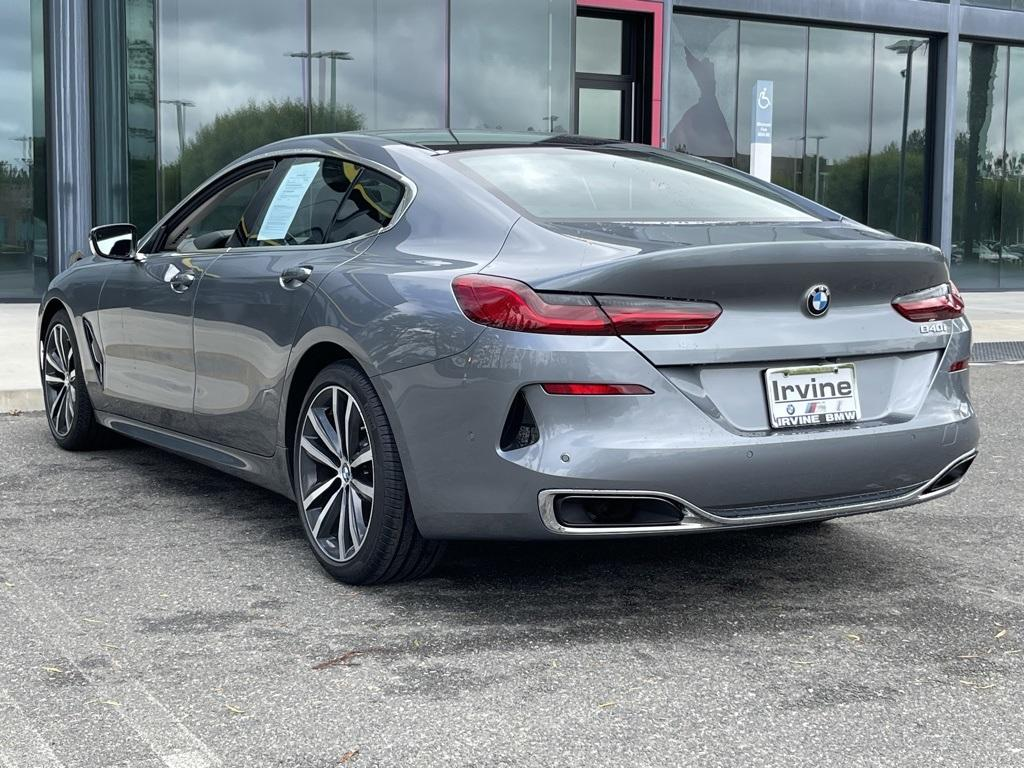

car 0.8323467969894409 -> tensor([0.4959, 0.4648, 0.9209, 0.5965])
Car annotated frame:


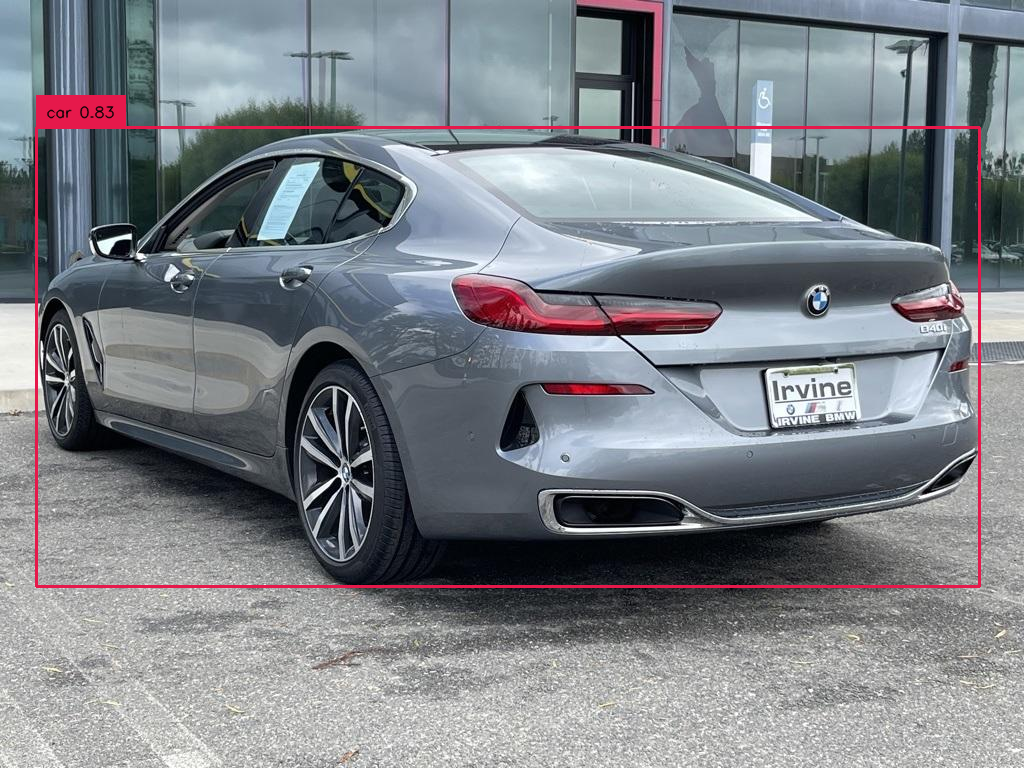

license plate 0.8113982081413269 -> tensor([0.7934, 0.5147, 0.0963, 0.0884])
Plate annotated frame:


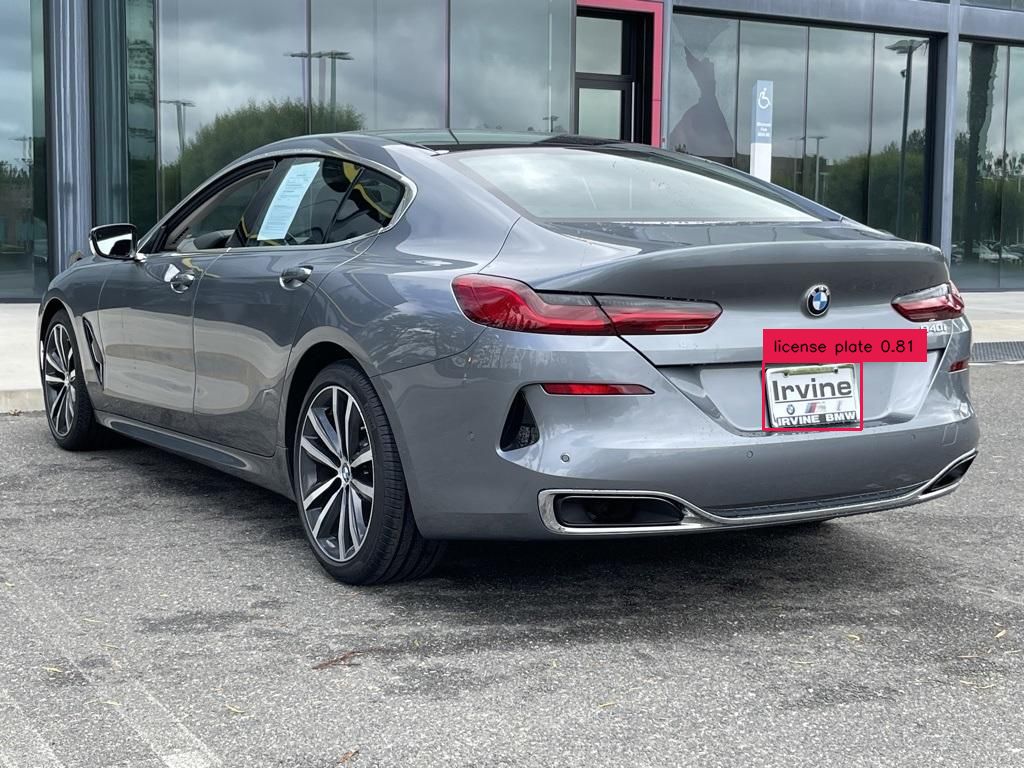

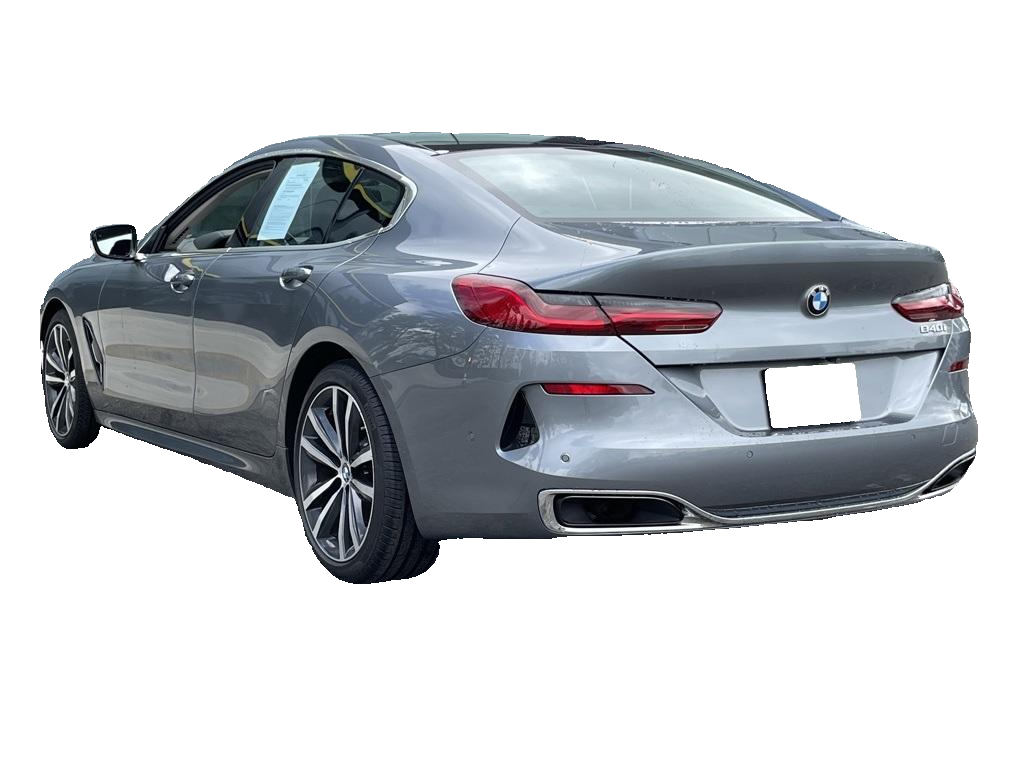

In [116]:
def run_inference(image_url):
  local_image_path = "assets/image.jpg"
  download_image(image_url, local_image_path)
  image_source, image = load_image(local_image_path)
  display(Image.fromarray(image_source))

  boxes = []

  car_annotated_frame, car_boxes, car_logits, car_phrases = detect(image_source, image, text_prompt="car", model=groundingdino_model, box_threshold=0.8)
  if len(car_boxes) > 0:
    for (phrase, logit, box) in zip(car_phrases, car_logits, car_boxes):
      print(f"{phrase} {logit} -> {box}")
      boxes.append(box)
  else:
    print("No car boxes detected")
  print("Car annotated frame:")
  display(Image.fromarray(car_annotated_frame))

  plate_annotated_frame, plate_boxes, plate_logits, plate_phrases = detect(image_source, image, text_prompt="license plate", model=groundingdino_model, box_threshold=0.5)
  if len(plate_boxes) > 0:
    for (phrase, logit, box) in zip(plate_phrases, plate_logits, plate_boxes):
      print(f"{phrase} {logit} -> {box}")
      boxes.append(box)
  else:
    print("No plate boxes detected")
  print("Plate annotated frame:")
  display(Image.fromarray(plate_annotated_frame))

  if len(boxes) != 2:
    return image_source

  segmented_frame_masks = segment(image_source, sam_predictor, boxes=torch.stack(boxes))
  mask = torch.logical_not(segmented_frame_masks[0] ^ segmented_frame_masks[1])
  result = cutout(image_source, mask[0])
  return result

image_url = "http://vehicle-photos-published.vauto.com/9f/ce/1c/de-a061-42c0-b496-e48cd4134d65/image-6.jpg"

result = run_inference(image_url)

display(Image.fromarray(result))